In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# ───────────────────────────────────────────────────────────────
# Load the best model, preprocessor, and processed test data
# ───────────────────────────────────────────────────────────────

print("Loading processed data and model...")

X_test  = np.load('../data/X_test_processed.npy')
y_test  = np.load('../data/y_test.npy')

# Load the preprocessor (now with OrdinalEncoder)
preprocessor = joblib.load('../models/diabetes_preprocessor.joblib')

# Load best model (Logistic Regression - non-SMOTE)
model = joblib.load('../models/best_diabetes_model_Logistic_Regression.joblib')
print("Model loaded:", model)

# Load clean feature names (saved in preprocessing)
feature_names_df = pd.read_csv('../data/processed_feature_names.csv')
feature_names = feature_names_df['feature'].values
print(f"Number of features: {len(feature_names)}")
print("First 10 features:", feature_names[:10])
print("Last 10 features: ", feature_names[-10:])

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
print(f"\nTest AUC-ROC (Logistic Regression): {auc:.4f}")

Loading processed data and model...
Model loaded: LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
Number of features: 21
First 10 features: ['num__BMI' 'num__MentHlth' 'num__PhysHlth' 'ord__GenHlth' 'ord__Age'
 'ord__Education' 'ord__Income' 'remainder__HighBP' 'remainder__HighChol'
 'remainder__CholCheck']
Last 10 features:  ['remainder__Stroke' 'remainder__HeartDiseaseorAttack'
 'remainder__PhysActivity' 'remainder__Fruits' 'remainder__Veggies'
 'remainder__HvyAlcoholConsump' 'remainder__AnyHealthcare'
 'remainder__NoDocbcCost' 'remainder__DiffWalk' 'remainder__Sex']

Test AUC-ROC (Logistic Regression): 0.8196



Top 15 features by absolute coefficient:
                            feature  coefficient
0              remainder__CholCheck       1.2945
1      remainder__HvyAlcoholConsump      -0.7540
2                 remainder__HighBP       0.7374
3               remainder__HighChol       0.5824
4                      ord__GenHlth       0.5789
5                          num__BMI       0.4910
6                    remainder__Sex       0.2807
7   remainder__HeartDiseaseorAttack       0.2492
8                 remainder__Stroke       0.1934
9                          ord__Age       0.1500
10              remainder__DiffWalk       0.0995
11                remainder__Fruits      -0.0729
12         remainder__AnyHealthcare       0.0650
13                    num__PhysHlth      -0.0580
14                      ord__Income      -0.0574


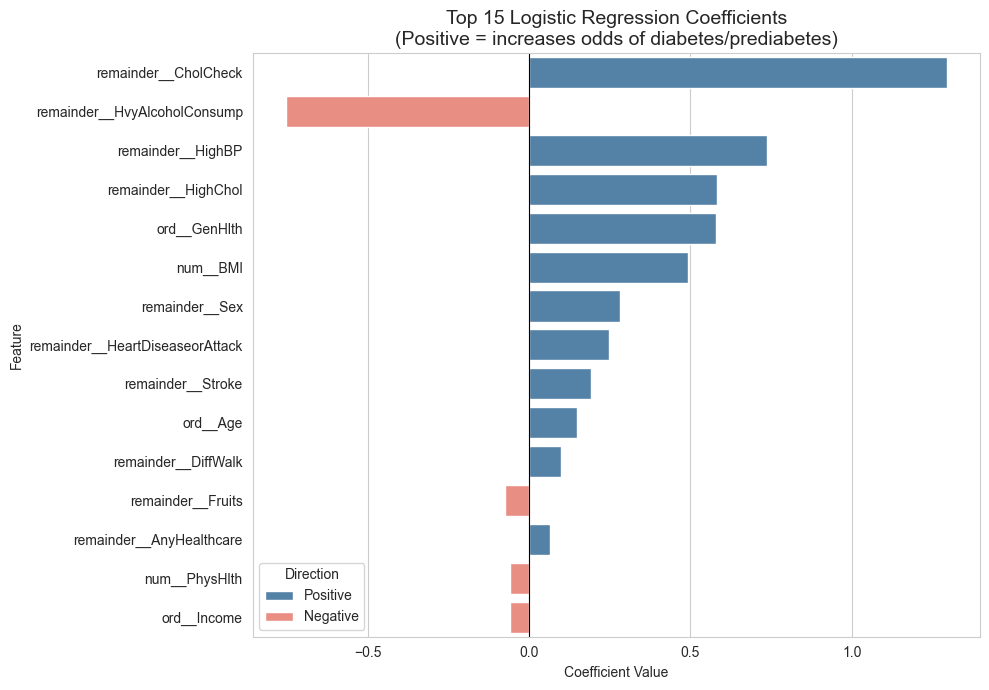

In [3]:
# ───────────────────────────────────────────────────────────────
# 3. Logistic Regression Coefficients (most interpretable)
# ───────────────────────────────────────────────────────────────
if hasattr(model, 'coef_'):
    coef = model.coef_[0]
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coef,
        'abs_coef': np.abs(coef)
    }).sort_values('abs_coef', ascending=False).reset_index(drop=True)
    
    print("\nTop 15 features by absolute coefficient:")
    print(coef_df.head(15)[['feature', 'coefficient']].round(4))
    
    # Plot top positive & negative coefficients
    plt.figure(figsize=(10, 7))
    top_n = 15
    plot_df = coef_df.head(top_n).copy()
    plot_df['sign'] = plot_df['coefficient'].apply(lambda x: 'Positive' if x > 0 else 'Negative')
    
    sns.barplot(
        data=plot_df,
        x='coefficient',
        y='feature',
        hue='sign',
        palette={'Positive': 'steelblue', 'Negative': 'salmon'},
        dodge=False
    )
    plt.axvline(0, color='black', linewidth=0.8)
    plt.title('Top 15 Logistic Regression Coefficients\n(Positive = increases odds of diabetes/prediabetes)', fontsize=14)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.legend(title='Direction')
    plt.tight_layout()
    plt.savefig('../figures/top_coefficients_ordinal.png', dpi=300, bbox_inches='tight')
    plt.show()


Computing permutation importance (this may take a minute)...

Top 15 features by permutation importance:
                            feature  importance
3                      ord__GenHlth      0.0600
0                          num__BMI      0.0333
4                          ord__Age      0.0258
7                 remainder__HighBP      0.0190
8               remainder__HighChol      0.0112
9              remainder__CholCheck      0.0049
16     remainder__HvyAlcoholConsump      0.0034
20                   remainder__Sex      0.0027
6                       ord__Income      0.0019
12  remainder__HeartDiseaseorAttack      0.0010
2                     num__PhysHlth      0.0004
19              remainder__DiffWalk      0.0003
5                    ord__Education      0.0002
11                remainder__Stroke      0.0001
1                     num__MentHlth      0.0001


C:\Users\matth\AppData\Local\Temp\ipykernel_6644\1194960330.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


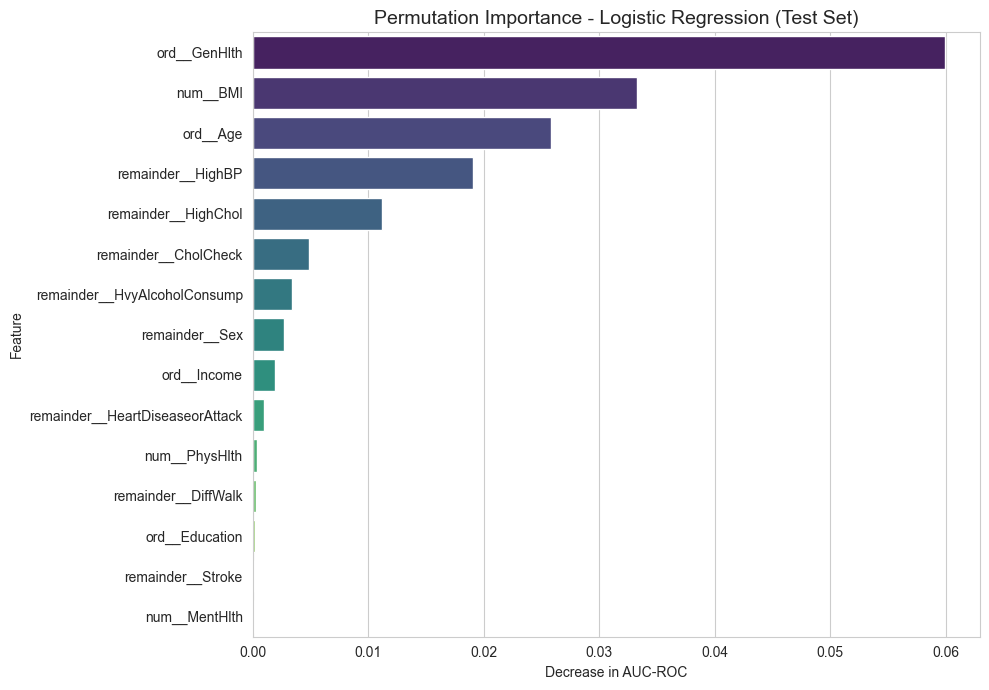

In [4]:
# ───────────────────────────────────────────────────────────────
# 4. Permutation Importance (model-agnostic)
# ───────────────────────────────────────────────────────────────
print("\nComputing permutation importance (this may take a minute)...")
perm_importance = permutation_importance(
    model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False)

print("\nTop 15 features by permutation importance:")
print(perm_df.head(15)[['feature', 'importance']].round(4))

# Plot
plt.figure(figsize=(10, 7))
sns.barplot(
    data=perm_df.head(15),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title('Permutation Importance - Logistic Regression (Test Set)', fontsize=14)
plt.xlabel('Decrease in AUC-ROC')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('../figures/permutation_importance_ordinal.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\matth\AppData\Local\Temp\ipykernel_6644\2419637190.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


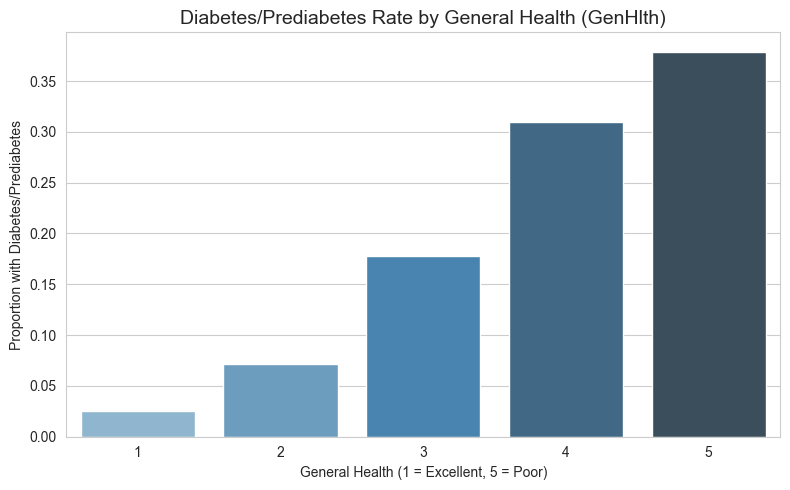

C:\Users\matth\AppData\Local\Temp\ipykernel_6644\2419637190.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


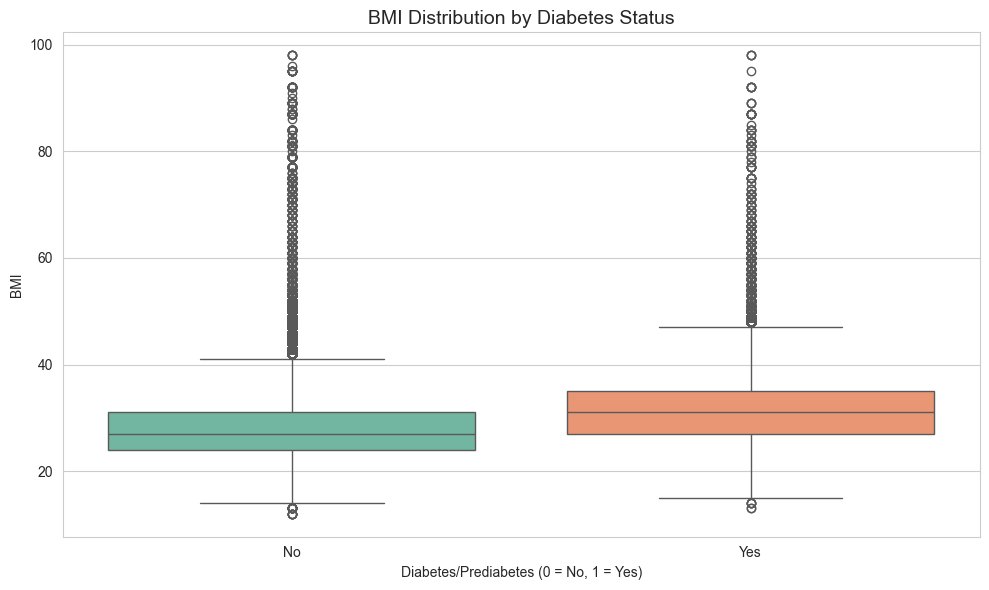

C:\Users\matth\AppData\Local\Temp\ipykernel_6644\2419637190.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


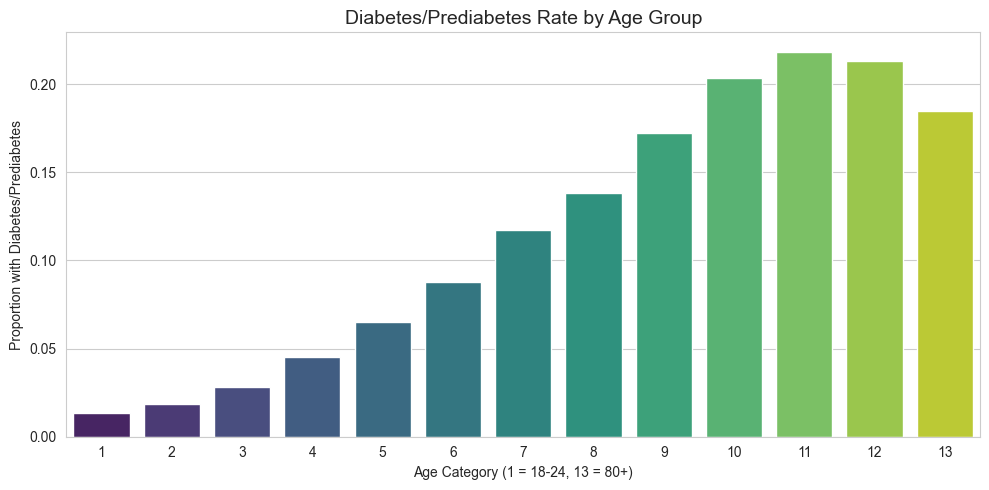


Notebook 04 complete. Key figures saved to ../figures/
Main insights remain similar, but now use ordinal-encoded features.
- GenHlth, Age, BMI, HighBP, HighChol are consistently top predictors.


In [5]:
# ───────────────────────────────────────────────────────────────
# 5. Key Risk Factor Visualizations (using original raw data)
# ───────────────────────────────────────────────────────────────
from ucimlrepo import fetch_ucirepo
diabetes = fetch_ucirepo(id=891)
df_original = pd.concat([diabetes.data.features, diabetes.data.targets], axis=1)

# GenHlth - strongest predictor
plt.figure(figsize=(8, 5))
sns.barplot(
    x='GenHlth',
    y='Diabetes_binary',
    data=df_original,
    errorbar=None,
    palette='Blues_d'
)
plt.title('Diabetes/Prediabetes Rate by General Health (GenHlth)', fontsize=14)
plt.ylabel('Proportion with Diabetes/Prediabetes')
plt.xlabel('General Health (1 = Excellent, 5 = Poor)')
plt.tight_layout()
plt.savefig('../figures/diabetes_rate_by_genhlth.png', dpi=300, bbox_inches='tight')
plt.show()

# BMI distribution
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Diabetes_binary',
    y='BMI',
    data=df_original,
    palette='Set2'
)
plt.title('BMI Distribution by Diabetes Status', fontsize=14)
plt.xlabel('Diabetes/Prediabetes (0 = No, 1 = Yes)')
plt.ylabel('BMI')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.savefig('../figures/bmi_dist_by_diabetes_status.png', dpi=300, bbox_inches='tight')
plt.show()

# Optional: Age buckets vs diabetes rate
plt.figure(figsize=(10, 5))
sns.barplot(
    x='Age',
    y='Diabetes_binary',
    data=df_original,
    errorbar=None,
    palette='viridis'
)
plt.title('Diabetes/Prediabetes Rate by Age Group', fontsize=14)
plt.ylabel('Proportion with Diabetes/Prediabetes')
plt.xlabel('Age Category (1 = 18-24, 13 = 80+)')
plt.tight_layout()
plt.savefig('../figures/diabetes_rate_by_age.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNotebook 04 complete. Key figures saved to ../figures/")
print("Main insights remain similar, but now use ordinal-encoded features.")
print("- GenHlth, Age, BMI, HighBP, HighChol are consistently top predictors.")